## Creating the 1000 m isobath

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40859,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34091,Total threads: 1
Dashboard: /proxy/39005/status,Memory: 35.97 GiB
Nanny: tcp://127.0.0.1:41923,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,608
file_id,44
path,5088
filename_timestamp,131
frequency,3
start_date,240
end_date,241
variable,201
variable_long_name,183
variable_standard_name,39


List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

For example:

## Extracting contour along the 1000 m isobath


In [28]:
#loading ocean static manually
ocean_static = xr.open_dataset('/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/output000/access-om3.mom6.static.nc')
# setting the yaxis maximumand minimum
lat_range = slice(-88, -59)
#cutting to the requires length
ocean_static = ocean_static.sel(yh=lat_range,yq=lat_range)
#definig contour depth
contour_depth = 1000 # metres
# separating variable
ht = ocean_static.deptho

Text(0.5, 1.0, 'Ocean depth (m)')

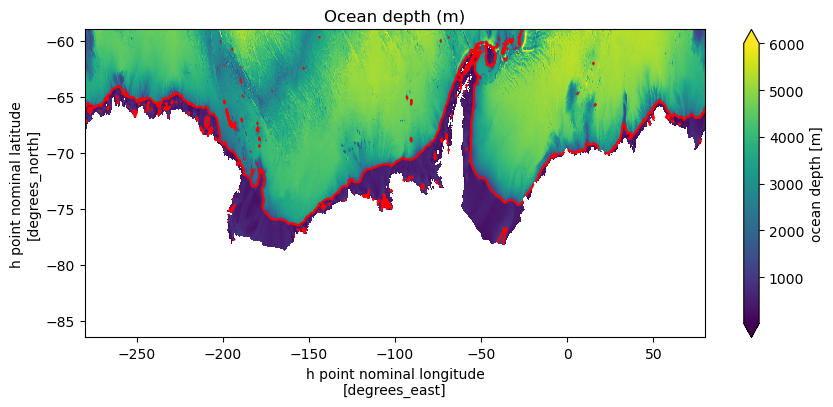

In [29]:
fig = plt.figure(figsize = (10, 4))

ht.plot(extend='both', cbar_kwargs={'label': "ocean depth [m]"})
ht.plot.contour(levels = [contour_depth], colors = 'r', linestyles = '-')
plt.title('Ocean depth (m)')

In [30]:
ht = ht.fillna(0).load()

In [32]:
grid_sel = 't'
x_var = ht['xh']
y_var = ht['yh']

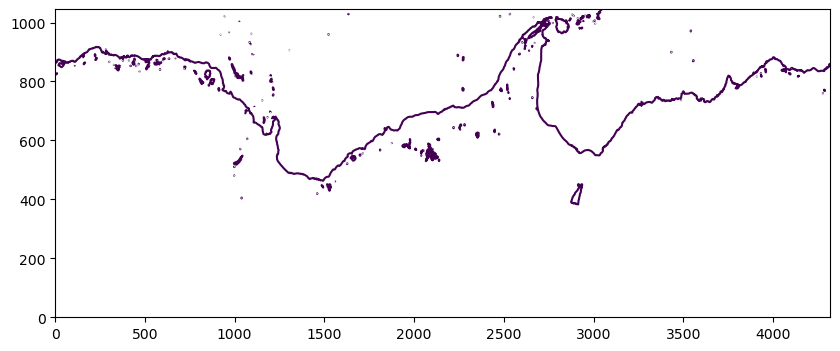

In [33]:
fig = plt.figure(figsize = (10, 4))
sc = plt.contour(ht, levels=[contour_depth])

path_vertices = (sc.get_paths()[0]).vertices
x_vertices = path_vertices[:, 0]
y_vertices = path_vertices[:, 1]

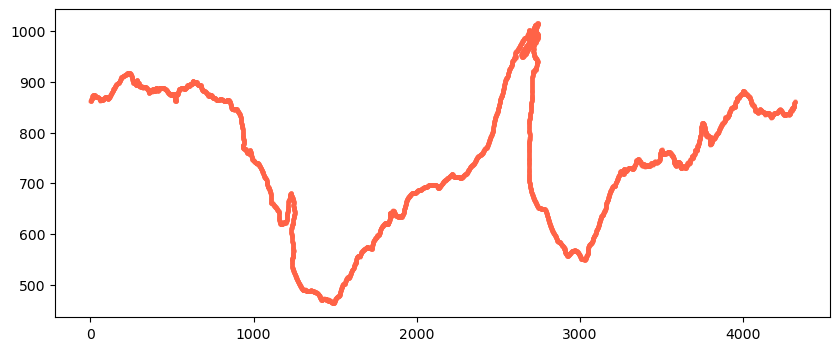

In [34]:
last_contour_index = np.where(np.abs(np.diff(x_vertices).astype(int)) > 1)[0][0]

x_contour = x_vertices[:last_contour_index + 1]
y_contour = y_vertices[:last_contour_index + 1]

# Check desired contour looks right:
fig = plt.figure(figsize = (10, 4))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [35]:
x_contour = np.round(x_contour).astype(int)
y_contour = np.round(y_contour).astype(int)

# check that the difference between coords of contour never increase by more than 1:
if np.max(np.abs(np.diff(x_contour))) != 1:
    print('help! x_contour increases by more than 1 between coords.')

if np.max(np.abs(np.diff(y_contour))) != 1:
    print('help! y_contour increases by more than 1 between coords.')

In [36]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [37]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    x_contour = np.delete(x_contour, index)
    y_contour = np.delete(y_contour, index)

In [38]:
ht_contour = np.zeros(len(x_contour))

for ii in range(len(ht_contour)):
    ht_contour[ii] = ht[y_contour[ii], x_contour[ii]]

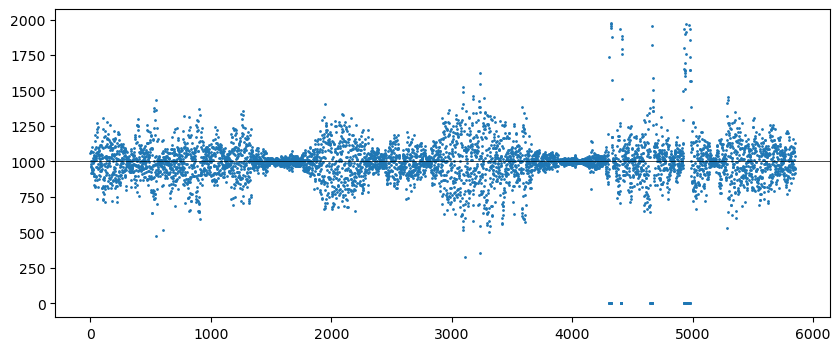

In [39]:
fig = plt.figure(figsize=(10, 4))

plt.plot(ht_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [40]:
# Number of grid points on the contour
num_points = len(x_contour)

# start numbering from 1 not 0:
contour_mask_numbered = np.arange(1, len(x_contour)+1)

contour_mask = xr.zeros_like(ht)

for ii in range(num_points):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]

In [43]:
import cmocean

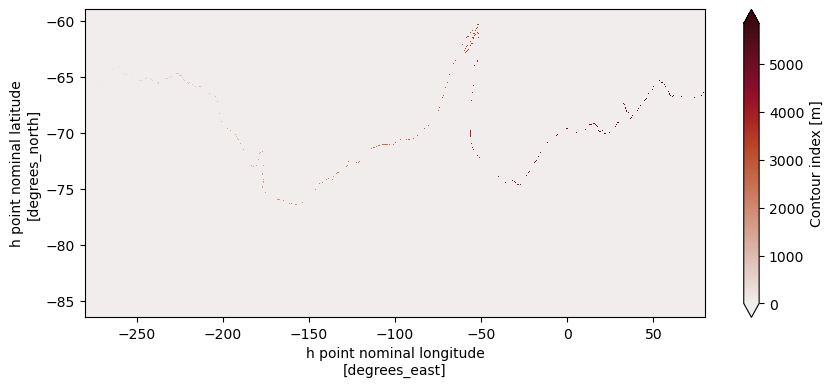

In [45]:
contour_mask.attrs['long_name'] = 'Contour index'
plt.figure(1, figsize=(10, 4))
contour_mask.plot(extend='both', cmap = cmocean.cm.amp);

In [48]:
%%time

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xh)-1):
    for jj in range(len(contour_mask.yh))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xh))[::-1][:-1]:
    for jj in range(len(contour_mask.yh))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xh))[::-1][:-1]:
    for jj in range(len(contour_mask.yh)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xh)-1):
    for jj in range(len(contour_mask.yh)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

CPU times: user 7.14 s, sys: 91.2 ms, total: 7.23 s
Wall time: 7.17 s


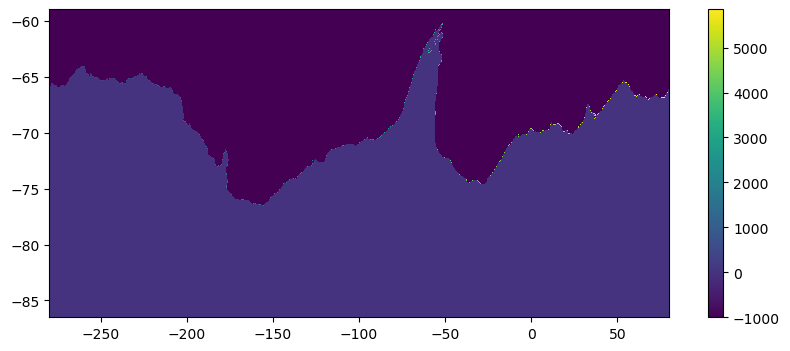

In [49]:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xh, contour_mask.yh, contour_masked_above)
plt.colorbar()

In [50]:
%%time
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1        
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
    # if point to left and right BOTH toward Antarctica
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1        
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

<timed exec>:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
<timed exec>:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
<timed exec>:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
<timed exec>:42: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
<timed exec>:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an 

CPU times: user 3min 40s, sys: 12.6 s, total: 3min 52s
Wall time: 2min 58s


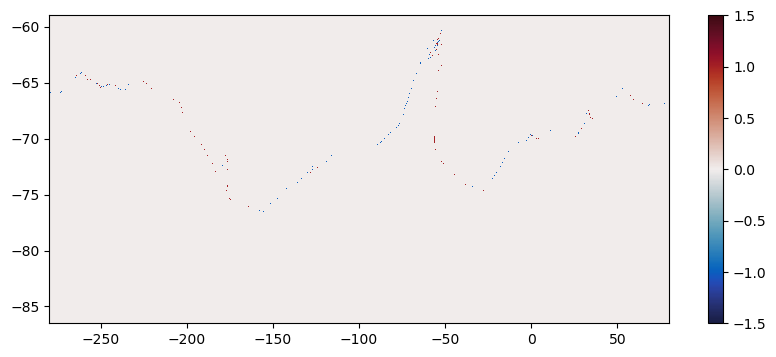

In [51]:
# Plot the mask for the x-transport:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xh, contour_mask.yh, mask_x_transport,
               cmap=cmocean.cm.balance, vmin=-1.5, vmax=1.5)
plt.colorbar();

In [67]:
#creatong hu
hu=ht.copy()
hu = hu.rename({'yh':'yq'}); hu['yq']=ocean_static.yq.values
hu = hu.rename({'xh':'xq'}); hu['xq']=ocean_static.xq[:-1].values

In [68]:
mask_x_transport = xr.DataArray(mask_x_transport,
                                coords = [ht.yh, hu.xq],
                                dims = ['latitude', 'longitude'])
mask_y_transport = xr.DataArray(mask_y_transport,
                                coords = [hu.yq, ht.xh],
                                dims = ['latitude', 'longitude'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
                                         coords = [ht.yh, hu.xq],
                                         dims = ['latitude', 'longitude'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
                                         coords = [hu.yq, ht.xh],
                                         dims = ['latitude', 'longitude'])

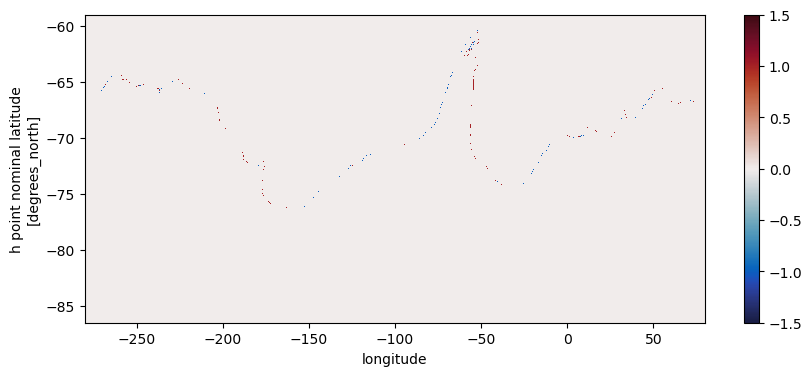

In [69]:
plt.figure(1, figsize=(10, 4))

mask_x_transport.plot(cmap=cmocean.cm.balance, vmin=-1.5, vmax=1.5);

In [70]:
# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [94]:
#importing transports
vmo = esm_datastore.search(variable="vmo").\
to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).\
vmo.sel(yq = lat_range).chunk(chunks={"time": -1})

umo = esm_datastore.search(variable="umo").\
to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).\
umo.sel(yh = lat_range).chunk(chunks={"time": -1})


In [95]:
#renaming variables, slicing out the last 2 years
vmo = vmo.rename({'yq': 'latitude', 'xh': 'longitude'}).isel(time=slice(120-24,120))
umo = umo.rename({'yh': 'latitude', 'xq': 'longitude'}).isel(time=slice(120-24,120))

In [98]:
%%time

# weighed time mean by month length
days_in_month = vmo.time.dt.days_in_month
days_in_year = 365

umo = (umo * days_in_month / days_in_year).sum('time')
umo = umo.load()

vmo = (vmo * days_in_month / days_in_year).sum('time')
vmo = vmo.load()
umo

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 68.00 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 68.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 11min 8s, sys: 1min 5s, total: 12min 13s
Wall time: 12min 50s


<xarray.DataArray (rho2_l: 99, latitude: 1046, longitude: 4321)> Size: 4GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * rho2_l     (rho2_l) float64 792B 1.016e+03 1.033e+03 ... 1.037e+03 1.038e+03
  * longitude  (longitude) float64 35kB -280.0 -279.9 -279.8 ... 79.92 80.0
  * latitude   (latitude) float64 8kB -86.49 -86.47 -86.45 ... -59.05 -59.01

In [99]:
#converting transport to m3/s
ρ0 = 1035 # kg/m^3

vmo = vmo * mask_y_transport / ρ0 # convert kg/s -> m^3/s
umo = umo * mask_x_transport / ρ0 # convert kg/s -> m^3/s

In [101]:
## We could also loop in time if we didn't want the time average. 
# In that case, initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_transport_1d = umo.stack(contour_index = ['latitude', 'longitude'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = vmo.stack(contour_index = ['latitude', 'longitude'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()

/jobfs/146286998.gadi-pbs/ipykernel_2720577/3610625379.py:13: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['latitude', 'longitude'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'latitude', 'longitude'])` before assigning new coordinate values.
  vol_trans_across_contour.coords['contour_index'] = contour_index_array


In [102]:
rho_slice = slice(1037.18,1038) # targeting DSW here

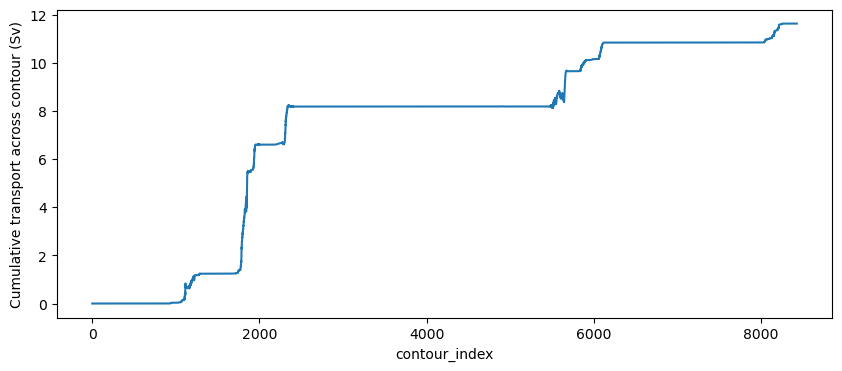

In [103]:
plt.figure(1, figsize=(10, 4))

(vol_trans_across_contour.sel(rho2_l=rho_slice).sum('rho2_l').cumsum('contour_index')/1e6).plot()
plt.ylabel('Cumulative transport across contour (Sv)'); 

In [104]:
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.latitude.copy()
lon_along_contour = contour_ordering.longitude.copy()

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

/jobfs/146286998.gadi-pbs/ipykernel_2720577/3395851563.py:11: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['latitude', 'longitude'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'latitude', 'longitude'])` before assigning new coordinate values.
  lat_along_contour.coords['contour_index'] = contour_index_array
/jobfs/146286998.gadi-pbs/ipykernel_2720577/3395851563.py:12: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['latitude', 'longitude'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'latitude', 'longitude'])` before assigning new coordinate values.
  lon_along_contour.coords['contour_index'] = contour_index_array


In [105]:
from geopy import distance

num_points = len(lat_along_contour)
d_distance_along_contour = np.zeros((num_points))

for i in range(num_points-1):
    d_distance_along_contour[i+1] = distance.distance((lat_along_contour[i], lon_along_contour[i]), (lat_along_contour[i+1], lon_along_contour[i+1])).km

distance_along_contour = np.cumsum(d_distance_along_contour)

In [106]:
target_lons = [-280, -240, -180, -120, -60, 0, 6., 80]

distance_indices = np.zeros_like(target_lons)

for j, lon in enumerate(target_lons):
    distance_indices[j] = np.argmin(np.abs((lon_along_contour.values - lon)))

In [107]:
rho2_to_integrate = 1037.18

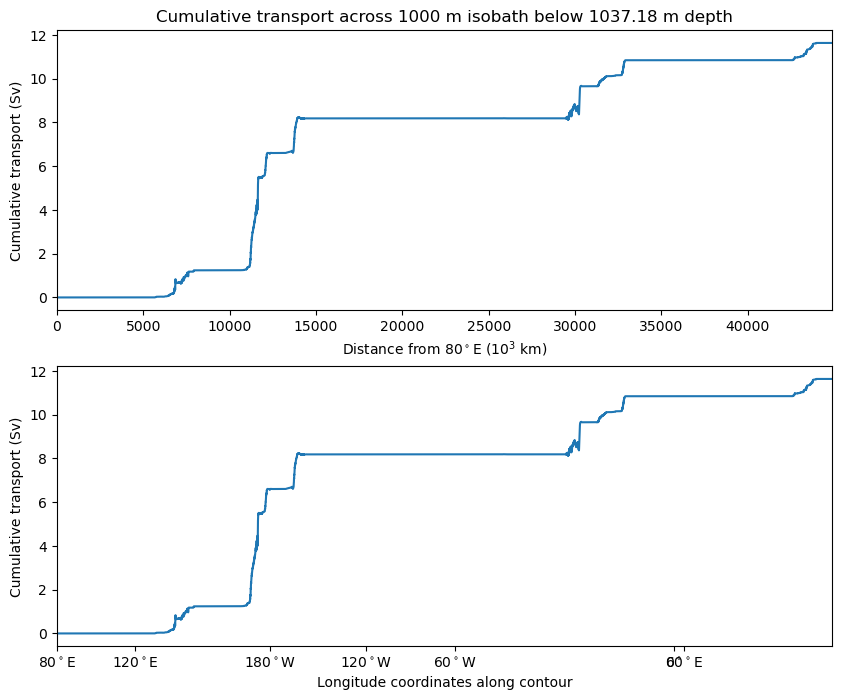

In [109]:
fig, axes = plt.subplots(nrows = 2, figsize = (10, 8))

# factor 1e-6 converts m^3/s -> Sv
axes[0].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(rho2_l = slice(rho2_to_integrate, 1038)).sum('rho2_l').cumsum('contour_index')))

axes[0].set_ylabel('Cumulative transport (Sv)')
axes[0].set_xlabel('Distance from 80$^\circ$E (10$^3$ km)')
axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Cumulative transport across {contour_depth} m isobath below {rho2_to_integrate} m depth')

# factor 1e-6 converts m^3/s -> Sv
axes[1].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(rho2_l = slice(rho2_to_integrate, 1038)).sum('rho2_l').cumsum('contour_index')))

axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes[1].set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Cumulative transport (Sv)');

In [181]:

shelf_mask = np.ma.masked_where(contour_masked_above>-999,contour_masked_above)
shelf_mask = ((contour_masked_above*0)+1)* shelf_mask.mask

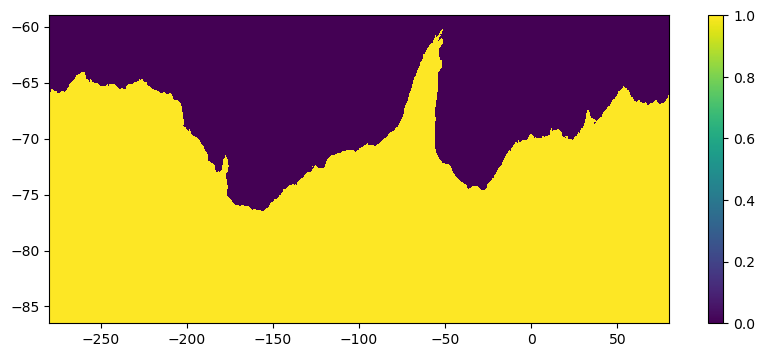

In [182]:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xh, contour_mask.yh,shelf_mask)
plt.colorbar()

In [187]:
#saving np file of the isobath
isobath_dir = '/home/156/wf4500/Claires_Hackathon/mom6-panAn-iceshelf-tools/evaluation/isobath_1000m_8km_jra_ryf_obc_Charrassin'



np.savez(isobath_dir, mask_x_numbered_1d=mask_x_numbered_1d\
         , mask_y_numbered_1d=mask_y_numbered_1d, mask_y_transport=mask_y_transport,\
        mask_x_transport = mask_x_transport, contour_ordering = contour_ordering,\
        contour_index_array = contour_index_array, lat_along_contour = lat_along_contour, lon_along_contour = lon_along_contour,\
        contour_masked_above=contour_masked_above, shelf_mask=shelf_mask)